# Making a Cat Breed Classifier with fast.ai

In [8]:
#hide
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [9]:
#hide
from fastbook import *
from fastai.vision.widgets import *

In [10]:
import os
key = os.environ.get('AZURE_SEARCH_KEY', 'xxx')

In [11]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [12]:
results = search_images_bing(key, 'persian cat')
ims = results.attrgot('contentUrl')
len(ims)

150

In [14]:
dest = 'images/persian_test.jpg'
download_url(ims[0], dest)

Path('images/persian_test.jpg')

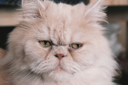

In [15]:
im = Image.open(dest)
im.to_thumb(128,128)

In [16]:
cat_breeds = 'persian','orange tabby','english shorthair'
path = Path('cats')

In [17]:
if not path.exists():
    path.mkdir()
    for o in cat_breeds:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o} cat')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [79]:
fns = get_image_files(path);
fns;

Often when we download files from the internet, there are a few that are corrupt. Let's check:

In [80]:
failed = verify_images(fns);

In [81]:
failed.map(Path.unlink);

In [82]:
cats = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

In [83]:
dls = cats.dataloaders(path);

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


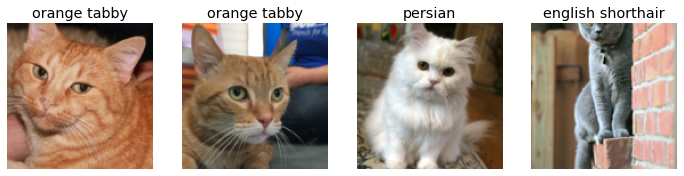

In [28]:
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


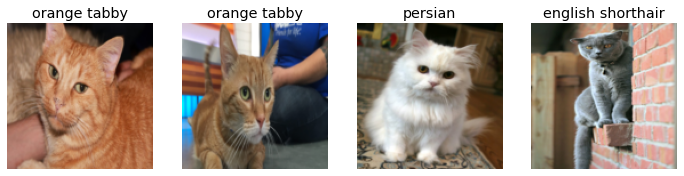

In [29]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


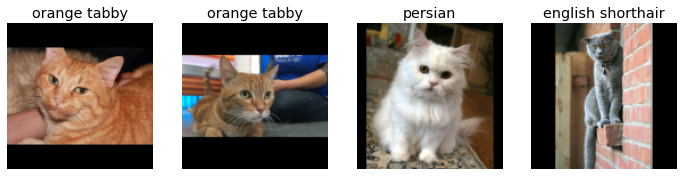

In [30]:
cats = cats.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = cats.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


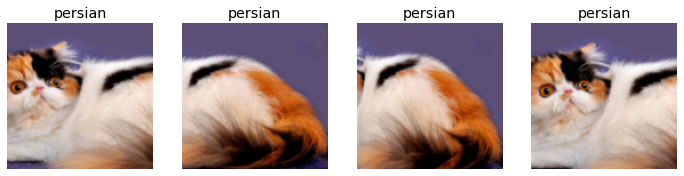

In [31]:
cats = cats.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = cats.dataloaders(path)
dls.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


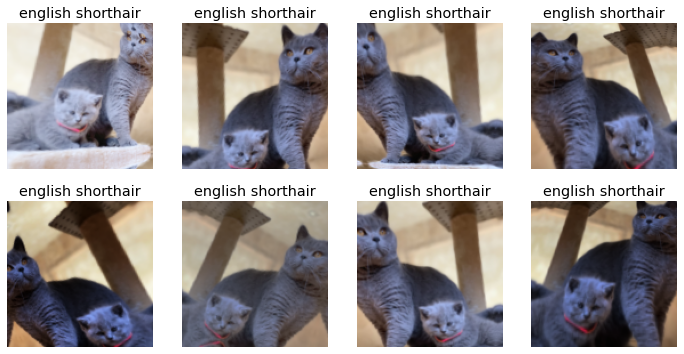

In [97]:
cats = cats.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2));
dls = cats.dataloaders(path);
dls.train.show_batch(max_n=8, nrows=2, unique=True)

In [33]:
cats = cats.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls = cats.dataloaders(path)

Due to IPython and Windows limitation, python multiprocessing isn't available now.
So `number_workers` is changed to 0 to avoid getting stuck


In [34]:
learn = cnn_learner(dls, resnet18, metrics=error_rate);
learn.fine_tune(4);

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\avngu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

epoch,train_loss,valid_loss,error_rate,time
0,1.255284,0.307520,0.126437,00:48


epoch,train_loss,valid_loss,error_rate,time
0,0.268112,0.206428,0.068966,00:58
1,0.225065,0.217868,0.057471,00:57
2,0.170241,0.246959,0.057471,00:56
3,0.131814,0.252035,0.057471,00:56


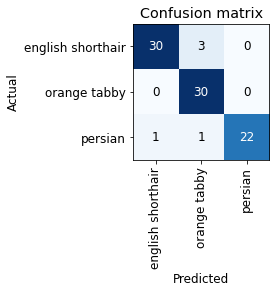

In [35]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

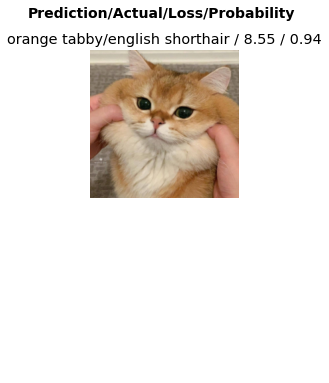

In [92]:
interp.plot_top_losses(1, nrows=2)

In [39]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

In [ ]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [60]:
learn.export()

In [61]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [62]:
learn_inf = load_learner(path/'export.pkl')

In [63]:
learn_inf.predict(r"G:\My Drive\fastai course\images\meeko1.jpeg")

('persian', TensorBase(2), TensorBase([7.0568e-07, 1.7875e-02, 9.8212e-01]))

In [64]:
learn_inf.dls.vocab

['english shorthair', 'orange tabby', 'persian']

In [65]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [84]:
img = PILImage.create(btn_upload.data[-1])

In [85]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [86]:
pred,pred_idx,probs = learn_inf.predict(img)

In [87]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: orange tabby; Probability: 0.9872')

In [93]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [94]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [95]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [96]:
#hide_output
VBox([widgets.Label('Select your cat!'), 
      btn_upload, btn_run, out_pl, lbl_pred])